In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from numpy import sqrt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,Dropout
from sklearn.preprocessing import LabelEncoder,StandardScaler

### Data Exploration and preparing for MLP

In [ ]:
df=pd.read_csv('myrides_02_Dataset_2.csv',sep=';')

In [ ]:
df

HR     Hm        km  ... rider_height  ride_type  duration
0    NaN  959,6  56,02812  ...          183   Training  02:32:02
1    NaN    444  16,43322  ...          183   Training  00:58:07
2    NaN  250,2  35,19066  ...          183    Pendeln  01:44:07
3    NaN  310,8  24,47906  ...          183   Training  00:54:38
4    NaN   28,4     3,237  ...          183   Training  00:20:33
..   ...    ...       ...  ...          ...        ...       ...
522  NaN  178,4  34,97122  ...          183    Pendeln  01:36:07
523  NaN  211,4  34,94262  ...          183    Pendeln  01:26:53
524  NaN  191,6  35,77877  ...          183    Pendeln  01:42:11
525  NaN  225,2  35,93287  ...          183    Pendeln  01:44:41
526  NaN  199,2  34,62327  ...          183    Pendeln  01:25:44

[527 rows x 22 columns]

In [ ]:
df.isna().sum() #checking null values 

HR                   483
Hm                     0
km                     0
maxHm                  0
maxRpm               372
max_speed              0
minHm                  0
position_lat_max       0
position_lat_min       0
position_long_max      0
position_long_min      0
rpm                  372
speed                  0
bike                   0
type                   0
date                   0
endtime                0
starttime              0
rider_weight           0
rider_height           0
ride_type              0
duration               0
dtype: int64

Attributes HR,rpm and maxRpm has more than 50% null values ,since we cannot fill them with null or mean of attribute which would change the distribution of attribute and finally we would not obtain better results. So we have to drop them.

In [ ]:
df.drop(columns=['HR','maxRpm','rpm'],inplace=True)

Since we have bike,type and ride_type as categorical attritbute ,we need to process them mapping them with numerical value , we'll use labelencoder for it.

In [ ]:
#checking the unique values
print(df['bike'].unique(),"\n",df['type'].unique(),"\n",df['ride_type'].unique())

['Rose PRO' 'Stevens Elite' 'CUBE AIM RACE' 'Carver Distaco 6000'
 'Mietrad - GHOST' 'Giant'] 
 ['Rennrad' 'Trecking' 'MTB'] 
 ['Training' 'Pendeln' 'Race']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Hm                 527 non-null    object
 1   km                 527 non-null    object
 2   maxHm              527 non-null    object
 3   max_speed          527 non-null    object
 4   minHm              527 non-null    object
 5   position_lat_max   527 non-null    object
 6   position_lat_min   527 non-null    object
 7   position_long_max  527 non-null    object
 8   position_long_min  527 non-null    object
 9   speed              527 non-null    object
 10  bike               527 non-null    object
 11  type               527 non-null    object
 12  date               527 non-null    object
 13  endtime            527 non-null    object
 14  starttime          527 non-null    object
 15  rider_weight       527 non-null    int64 
 16  rider_height       527 non-null    int64 
 1

* most of the attributes contain numerical value but due to some char like "," we cannot convert them to numeric format ,so we will replace "," with "." to make them fractional value .
* The duration is = endtime-starttime , so endtime and startime would not have much significane for the model while training so we can drop them as well.





In [ ]:

def remove_comma(df,col):
  df[col]=df[col].apply(lambda x: x.replace(",","."))
def hms_to_s(s):           ##converting time to seconds
    t = 0
    for u in s.split(':'):
        t = 60 * t + int(u)
    return t
def Clean(df,col_len):               ## clean the dataframe
  for col in df.columns[:col_len]:
    remove_comma(df,col)
  df["duration"] = df["duration"].apply(hms_to_s)
  
  df.drop(['date','rider_height','starttime','endtime'],axis=1,inplace=True)
  return df

In [ ]:

df=Clean(df,10) ## clean for first 10 columns including km

In [ ]:
df

Hm        km  maxHm  ... rider_weight ride_type duration
0    959.6  56.02812  666.2  ...           75  Training     9122
1      444  16.43322  558.4  ...           75  Training     3487
2    250.2  35.19066    393  ...           74   Pendeln     6247
3    310.8  24.47906  461.6  ...           76  Training     3278
4     28.4     3.237    539  ...           73  Training     1233
..     ...       ...    ...  ...          ...       ...      ...
522  178.4  34.97122    330  ...           75   Pendeln     5767
523  211.4  34.94262  322.2  ...           73   Pendeln     5213
524  191.6  35.77877  323.2  ...           73   Pendeln     6131
525  225.2  35.93287  343.4  ...           75   Pendeln     6281
526  199.2  34.62327    317  ...           73   Pendeln     5144

[527 rows x 15 columns]

In [ ]:
#encoding bike,type and ride_type attribute 
bike_enc=LabelEncoder()
type_enc=LabelEncoder()
ride_enc=LabelEncoder()

In [ ]:
df['bike']=bike_enc.fit_transform(df['bike'])
df['type']=type_enc.fit_transform(df['type'])
df['ride_type']=ride_enc.fit_transform(df['ride_type'])
pickle.dump(bike_enc, open('bike_enc.pkl', 'wb'))
pickle.dump(type_enc, open('type_enc.pkl', 'wb'))
pickle.dump(ride_enc, open('ride_enc.pkl', 'wb'))

In [ ]:
df=df.astype('float64') #converting dataframe to numerical datatype

In [ ]:
df

Hm        km  maxHm  max_speed  ...  type  rider_weight  ride_type  duration
0    959.6  56.02812  666.2    53.4096  ...   1.0          75.0        2.0    9122.0
1    444.0  16.43322  558.4    37.0836  ...   1.0          75.0        2.0    3487.0
2    250.2  35.19066  393.0    39.1680  ...   2.0          74.0        0.0    6247.0
3    310.8  24.47906  461.6    48.2688  ...   1.0          76.0        2.0    3278.0
4     28.4   3.23700  539.0    26.0676  ...   0.0          73.0        2.0    1233.0
..     ...       ...    ...        ...  ...   ...           ...        ...       ...
522  178.4  34.97122  330.0    38.4264  ...   2.0          75.0        0.0    5767.0
523  211.4  34.94262  322.2    40.0752  ...   2.0          73.0        0.0    5213.0
524  191.6  35.77877  323.2    39.5352  ...   2.0          73.0        0.0    6131.0
525  225.2  35.93287  343.4    39.7044  ...   2.0          75.0        0.0    6281.0
526  199.2  34.62327  317.0    40.7124  ...   2.0          73.0        0.0    5144.0

[527 rows x 15 columns]

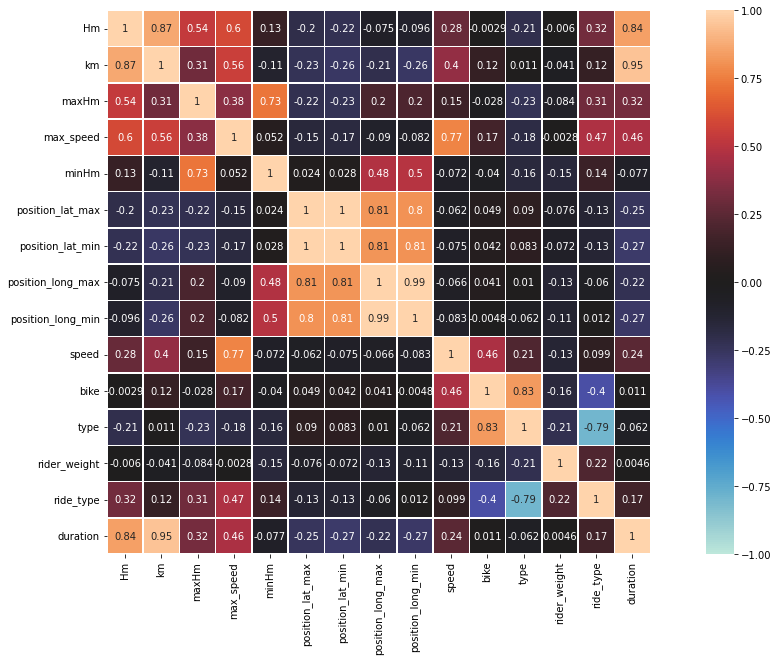

In [ ]:
##plotting correlation 
plt.figure(figsize = (20,10))
ax=sns.heatmap(df.corr(), annot = True,square=True,linewidths=.5,vmin=-1, vmax=1, center= 0)

We can see from above the Km travelled has most correlation with Hm,speed,duration, others have less correlated.

In [ ]:
df_scaler =StandardScaler()
X=df.loc[:,df.columns!='km'].values
y=df['km'].values
x = df_scaler.fit_transform(X)
pickle.dump(df_scaler, open('scaling_data.pkl', 'wb'))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y,random_state=1)  ### splitting data for train and test purpose

### Training with Keras DNN

In [ ]:
n_features = X_train.shape[1]
# define model
model = Sequential()
model.add(Dense(32, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(24, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
history=model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1)
# evaluate the model
error = model.evaluate(X_test, y_test, verbose=0)
print(f'MSE: {error:.3f}, RMSE: {sqrt(error):.3f}')

Epoch 1/200
13/13 [==============================] - 1s 1ms/step - loss: 2354.6941
Epoch 2/200
13/13 [==============================] - 0s 1ms/step - loss: 2297.2947
Epoch 3/200
13/13 [==============================] - 0s 1ms/step - loss: 2226.5269
Epoch 4/200
13/13 [==============================] - 0s 1ms/step - loss: 2143.4287
Epoch 5/200
13/13 [==============================] - 0s 1ms/step - loss: 2034.9435
Epoch 6/200
13/13 [==============================] - 0s 2ms/step - loss: 1898.4294
Epoch 7/200
13/13 [==============================] - 0s 2ms/step - loss: 1720.2228
Epoch 8/200
13/13 [==============================] - 0s 2ms/step - loss: 1488.0609
Epoch 9/200
13/13 [==============================] - 0s 2ms/step - loss: 1219.0930
Epoch 10/200
13/13 [==============================] - 0s 2ms/step - loss: 955.1937
Epoch 11/200
13/13 [==============================] - 0s 1ms/step - loss: 742.0953
Epoch 12/200
13/13 [==============================] - 0s 2ms/step - loss: 601.9237
Epoc

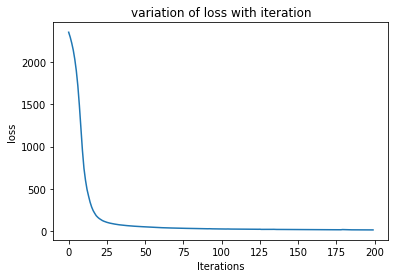

In [ ]:
##plot the loss change over iteration
plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.xlabel('Iterations')
plt.ylabel('loss')
plt.title('variation of loss with iteration')

plt.show()


In [ ]:
##dict to save loss and score for different learning rate
rate={}
data={}

### Training with MLP regressor

In [ ]:
lr=[0.001,0.003,0.02,0.03,0.1]
for i in range(len(lr)):
  ## training with adaptive leaning 
  regr = MLPRegressor(random_state=2, max_iter=200,alpha=0.1,learning_rate='adaptive',learning_rate_init=lr[i]).fit(X_train, y_train)
  y_pred=regr.predict(X_test)
  regr.score(X_test, y_test)
  rate[i]={'lr':lr[i],'val':regr.loss_curve_}
  data[lr[i]]=[mean_squared_error(y_test, y_pred),explained_variance_score(y_test, y_pred),regr.score(X_test, y_test)]

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
iter=range(0,300)

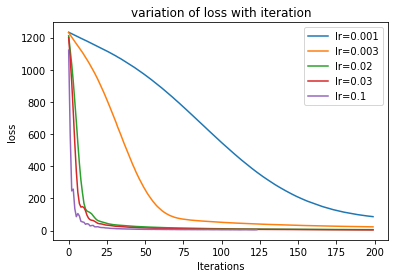

In [ ]:
for key in rate:
  plt.plot(range(len(rate[key]['val'])), rate[key]['val'], label ='lr='+str(rate[key]['lr']) )
plt.xlabel('Iterations')
plt.ylabel('loss')
plt.title('variation of loss with iteration')
plt.legend()
plt.show()

From graph we can see that as the learning rate increase the descent gets faster,and for less learing rate the model hasn't converge for even 200 iteration also e.x. lr=0.001, So we need to choose best learning rate for better result by looking at score and errors.

In [ ]:
##dataframe for score and error 
perform=pd.DataFrame.from_dict(data, orient='index',
                       columns=['MSE', 'var', 'R2'])

In [ ]:
perform

MSE       var        R2
0.001  266.854633  0.865751  0.851280
0.003  128.706640  0.931630  0.928271
0.020   94.675167  0.948394  0.947237
0.030   80.902730  0.956173  0.954912
0.100   88.754697  0.952480  0.950536

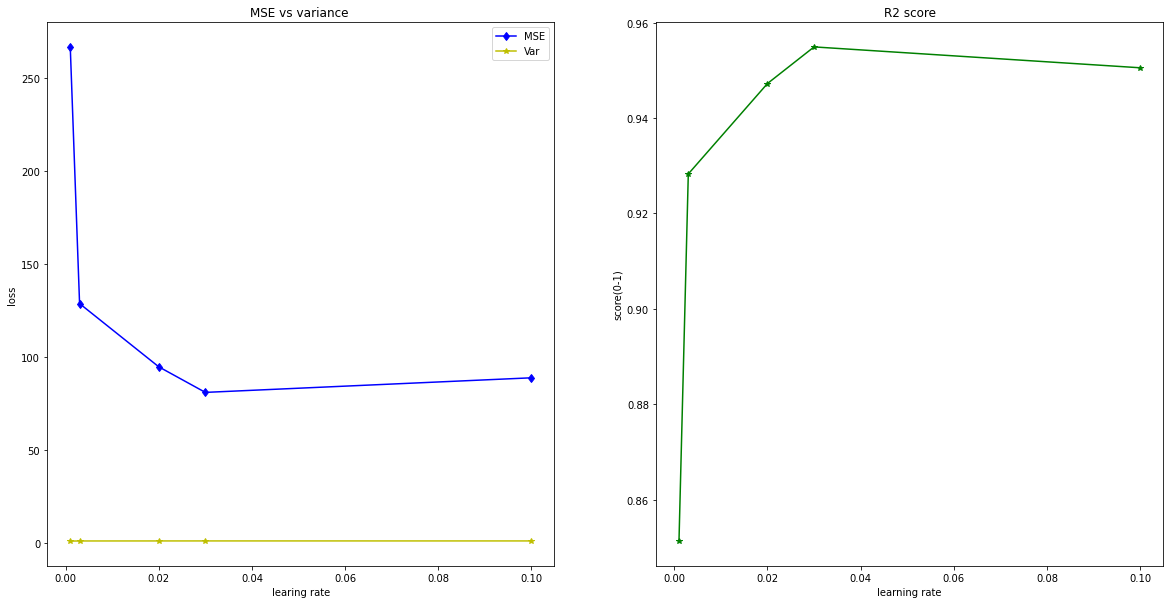

In [ ]:
##plotting score and error
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 10))
ax1.plot(perform.index,perform['MSE'], marker='d', color='b', label='MSE')
ax1.plot(perform.index,perform['var'], marker='*', color='y', label='Var')
ax1.set_title('MSE vs variance ')
ax1.set_xlabel("learing rate")
ax1.legend(loc="upper right")
ax1.set_ylabel("loss")
ax2.plot(perform.index,perform['R2'], marker='*', color='g', label='R2_score')
ax2.set_title('R2 score')
ax2.set_xlabel("learning rate")
ax2.set_ylabel("score(0-1)")
plt.show()

We can see that for learing rate 0.03  the curve has elbow change after which the score is decresing adn similarly loss is also slightly increasing from the left plot .

In [ ]:
## traning model  with lr=0.03 for new input data
regr = MLPRegressor(random_state=2, max_iter=200,alpha=0.03,learning_rate='adaptive',learning_rate_init=lr[i]).fit(x, y)

with open('mlp_model.pkl', 'wb') as fid: ##savig model
  pickle.dump(regr, fid)

### predicting for new input data.

In [ ]:
input_df=pd.read_csv('input_data.csv',sep=';',)
input_df.drop(columns=['HR','maxRpm','rpm'],inplace=True)
input_df=input_df.loc[:, ~input_df.columns.str.match('Unnamed')]
input_df=Clean(input_df,9) #clean first 9 col , because we do not km as attribute
## loading encoder 
 
bike_encod=pickle.load( open('bike_enc.pkl', 'rb'))
type_encod=pickle.load( open('type_enc.pkl', 'rb'))
ride_encod=pickle.load( open('ride_enc.pkl', 'rb'))
feature_scalar=pickle.load(open('scaling_data.pkl', 'rb'))
##using encoder and scaler
input_df['bike']=bike_encod.transform(input_df['bike'])
input_df['type']=type_encod.transform(input_df['type'])
input_df['ride_type']=ride_encod.transform(input_df['ride_type'])

input_df=input_df.astype('float64')

x = feature_scalar.fit_transform(input_df.loc[:,input_df.columns!='km'].values)
##load MLP model
with open('mlp_model.pkl', 'rb') as fid:
    model = pickle.load(fid)

y_pred=model.predict(x)

In [ ]:
print("Predicted values:",y_pred)

Predicted values: [ 44.40092025  12.7342005   38.65632895  21.25393243  16.32445413
 145.39179859  28.47696251  32.60018051  29.38479169  43.67292549]
